## LSTM Demo (From Chapter 6)

[Book Github Repo](https://github.com/EdwardRaff/Inside-Deep-Learning)

As in Chapter 6 we'll compare a 3 layer RNN to an LSTM on the problem of classifying names into languages.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm #may not work

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_simple_network, Flatten, weight_reset

/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/ipykernel_21792/3207106799.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm #may not work


In [2]:
torch.backends.cudnn.deterministic=True
from idlmam import set_seed, moveTo
set_seed(42)

In [3]:
def detect_device():
    if torch.cuda.is_available():
        print("CUDA is available")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("MPS (Apple Silicon) is available")
        return torch.device("mps")
    else:
        print("Only cpu is available")
        return torch.device("cpu")

device = detect_device()
print(f"Your device is using: {device}")

MPS (Apple Silicon) is available
Your device is using: mps


## Copied Code from Chapter 4

### Get the data and decompress it

In [4]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Zip file is organized as data/names/[LANG].txt , where [LANG] is a specific language

### Convert Unicode to ASCII

In [5]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing-wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


### Dataset and Dataloaders

In [13]:
class LanguageNameDataset(Dataset):
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label

### Extracting the hidden state:

In [14]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple, 
            last_step = last_step[0]#then h_t is the first item in the tuple
        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [15]:
def pad_and_pack(batch):
    #1, 2, & 3: organize the batch input lengths, inputs, and outputs as seperate lists
    input_tensors = []
    labels = []
    lengths = []
    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0]) #Assume shape is (T, *)
    #4: create the padded version of the input
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=True)
    #5: create the packed version from the padded & lengths
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=True, enforce_sorted=False)
    #Convert the lengths into a tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    #6: return a tuple of the packed inputs and their labels
    return x_packed, y_batched


In [16]:
class EmbeddingPackable(nn.Module):
    """
    The embedding layer in PyTorch does not support Packed Sequence objects. 
    This wrapper class will fix that. If a normal input comes in, it will 
    use the regular Embedding layer. Otherwise, it will work on the packed 
    sequence to return a new Packed sequence of the appropriate result. 
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)


## A 3 layer RNN for a baseline

This is the network from page 246 of the textbook. For faster training we'll make both the RNN and the LSTM uni-directional.

In [17]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

rnn_3layer = nn.Sequential(
    EmbeddingPackable( nn.Embedding(vocab_size, D) ),
    nn.RNN(D, hidden_nodes,num_layers=3,batch_first=True), 
    LastTimeStep(rnn_layers=3),
    nn.Linear(hidden_nodes, classes),
)

# apply gradient clipping to increase performance
for p in rnn_3layer.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

In [18]:
B = 32
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

In [19]:
loss_func = nn.CrossEntropyLoss()
rnn3_layer_train = train_simple_network(rnn_3layer, 
                                    loss_func, 
                                    train_loader, 
                                    test_loader=test_loader, 
                                    score_funcs={'Accuracy': accuracy_score}, 
                                    device=device, 
                                    epochs=5)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

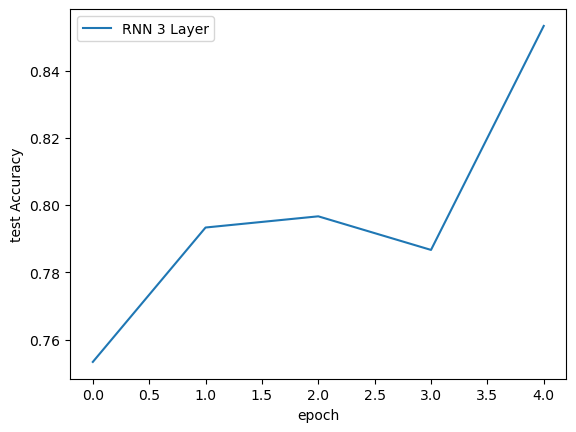

In [21]:
sns.lineplot(x='epoch', y='test Accuracy', data = rnn3_layer_train, label='RNN 3 Layer')

## 3 Layer LSTM (unidirectional)

Pytorch makes this very easy.  Change nn.RNN to nn.LSTM.  The LSTM will actually return both the hidden state and the context state, but the LastTimeStep class from Chapter 4 anticipated this and works fine.

In [23]:
lstm_3layer = nn.Sequential(
    EmbeddingPackable( nn.Embedding(vocab_size, D) ),
    nn.LSTM(D, hidden_nodes,num_layers=3,batch_first=True), 
    LastTimeStep(rnn_layers=3),
    nn.Linear(hidden_nodes, classes),
)

# apply gradient clipping to increase performance
for p in lstm_3layer.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

lstm3_layer_train = train_simple_network(lstm_3layer, 
                                    loss_func, 
                                    train_loader, 
                                    test_loader=test_loader, 
                                    score_funcs={'Accuracy': accuracy_score}, 
                                    device=device, 
                                    epochs=5)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

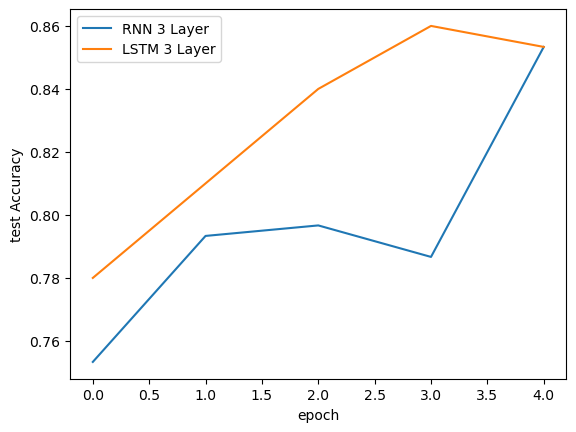

In [24]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn3_layer_train, label='RNN 3 Layer')
sns.lineplot(x='epoch', y='test Accuracy', data=lstm3_layer_train, label='LSTM 3 Layer')